In [1]:
import lightkurve as lk
import giants as g
import numpy as np
import matplotlib.pyplot as plt
import scipy
from astropy.stats import BoxLeastSquares
import starry
from astropy import units as u
from astropy.constants import G

In [2]:
# tic = 334776134
# tic = 287098442
tic = 161377136

In [3]:
lcc = g.Giant().from_eleanor(tic)

KeyboardInterrupt: 

In [ ]:
lc = lcc[1]
plt.plot(lc.time, lc.flux, label=lc.label)

In [ ]:
# mask first 12h after momentum dump
momdump = (lc.time > 1339) * (lc.time < 1341)
# also the burn in
burnin = np.zeros_like(lc.time, dtype=bool)
burnin[:120] = True
# also 6 sigma outliers
_, outliers = lc.remove_outliers(sigma=6, return_mask=True)
mask = momdump | burnin | outliers
lc.time = lc.time[~mask]
lc.flux = lc.flux[~mask]
lc.flux_err = lc.flux_err[~mask]

In [ ]:
lc.flux = lc.flux - 1
lc.flux = lc.flux - scipy.ndimage.filters.gaussian_filter(lc.flux, 100)

In [ ]:
lc.plot()

In [ ]:
# sneaky nonsense to allow interact_bls
# lc5 = lk.search_lightcurvefile('k2-199')[0].download()

In [ ]:
# lc.time_format = 'jd'
# lc.quality = np.ones(len(lc.time), dtype='int')
# lc.cadenceno = lc5.cadenceno[:len(lc.time)]

In [ ]:
# lc.flatten(window_length=91).remove_outliers().interact_bls('localhost:8888')

In [ ]:
model = BoxLeastSquares(lc.time, lc.flux)
results = model.autopower(0.16)
period = results.period[np.argmax(results.power)]
t0 = results.transit_time[np.argmax(results.power)]

In [ ]:
# period = bls.period_at_max_power.value
# t0 = bls.transit_time_at_max_power

In [ ]:
lc.plot()

In [ ]:
ax = lc.fold(period, t0).scatter(c='k', label=f'folded at {period:.3f} days')
lc.fold(period, t0).bin(binsize=7).plot(ax=ax, c='r', label='binned', lw=2)
ax.set_xlim([-0.5, .5])
ax.set_ylim([-.002, .002])

In [ ]:
def create_starry_model(time, rprs=.01, period=15., t0=5., i=90, ecc=0., m_star=1.):
    """ """
    # instantiate a starry primary object (star)
    star = starry.kepler.Primary()

    # calculate separation
    a = _calculate_separation(m_star, period)

    # quadradic limb darkening
    star[1] = 0.40
    star[2] = 0.26

    # instantiate a starry secondary object (planet)
    planet = starry.kepler.Secondary(lmax=5)

    # define its parameters
    planet.r = rprs * star.r
    planet.porb = period
    planet.tref = t0
    planet.inc = i
    planet.ecc = ecc
    planet.a = star.r*(a*u.AU).to(u.solRad).value # in units of stellar radius

    # create a system and compute its lightcurve
    system = starry.kepler.System(star, planet)
    system.compute(time)

    # return the light curve
    return system.lightcurve

def _calculate_duration(rprs, period, i):
    """ """

    a = .001
    b = ((1 + rprs)**2 - ((1/a)*np.cos(i*u.deg))**2) / (1 - np.cos(i*u.deg)**2)

    dur = (period / np.pi) * np.arcsin(a * b**1/2).value
    return dur

def _calculate_separation(m_star, period):
    """ """

    a = (((G*m_star*u.solMass/(4*np.pi**2))*(period*u.day)**2)**(1/3))

    return a.to(u.AU).value

In [ ]:
model_flux = create_starry_model(lc.time, period=period, t0=t0, rprs=.02) - 1
model_lc = lk.LightCurve(time=lc.time, flux=model_flux)

In [ ]:
ax = lc.fold(period, t0).scatter(c='k', label=f'folded at {period:.3f} days')
lc.fold(period, t0).bin(binsize=7).plot(ax=ax, c='r', label='binned', lw=2)
model_lc.fold(period, t0).plot(ax=ax, c='b', lw=2)
ax.set_xlim([-0.5, .5])
ax.set_ylim([-.002, .002])

In [ ]:
ax = lc.scatter()
model_lc.plot(ax=ax, c='r')

In [ ]:
target = g.Giant()
# target.validate_transit(ticid='TIC 438832923')
target.validate_transit(ticid='TIC 401772466')

In [ ]:
target.plot_gaia_overlay(ticid=401772466)

In [ ]:
target = g.Giant()

In [ ]:
target.plot(ticid=188628503)

In [ ]:
model, model_lc = target.fit_starry_model(minimum_period=18)

In [ ]:
target.plot_starry_model(minimum_period=18, r_star_prior=10.492, t_star_prior=4900)

In [ ]:
ax = target.lc.scatter()
model_lc.plot(ax=ax, c='r', lw=2)
ax.set_

In [ ]:
with model:
    period = model.map_soln['period']
    t0 = model.map_soln['t0']
    r_pl = model.map_soln['r_pl']

In [ ]:
ax = target.lc.fold(period, t0).scatter()
model_lc.fold(period, t0).plot(ax=ax, c='r', lw=2)
ax.set_xlim(-0.5, 0.5)
ax.set_ylim(-.0015, .0015)

In [ ]:
string = rf'd=${r_pl}$'

In [ ]:
string

In [ ]:
model.map_soln

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2910: DtypeWarning: Columns (85,115) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Creating light curve for target 13098223 for sectors [2].


100%|██████████| 1245/1245 [00:20<00:00, 61.34it/s]


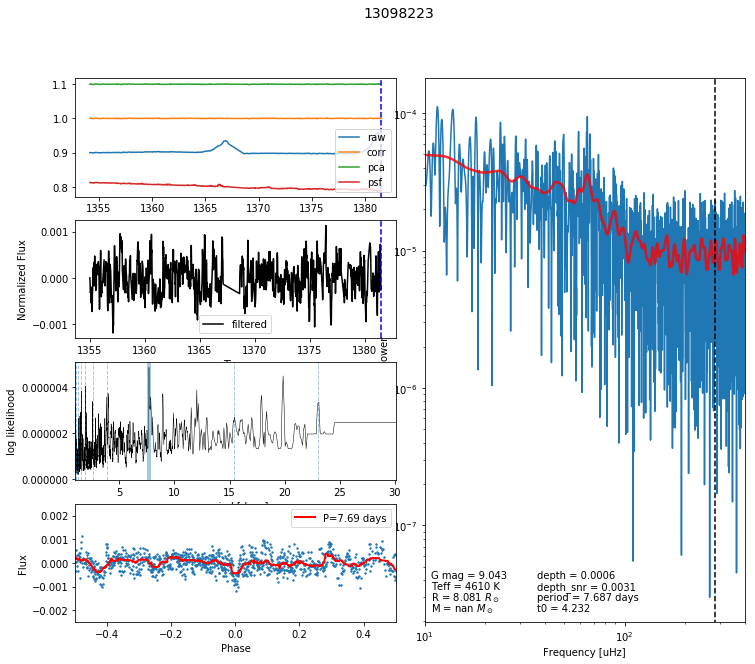

In [26]:
target = g.Giant()
target.plot(ticid=13098223, lc_source='eleanor')
#13097488,257725764,382452137
# 370325408 maybe a planet?

optimizing logp for variables: ['t0', 'period_interval__']
message: Desired error not necessarily achieved due to precision loss.
logp: -650433.4573552677 -> -638098.4178386757
optimizing logp for variables: ['mean', 'r_pl_interval__']
message: Desired error not necessarily achieved due to precision loss.
logp: -638098.4178386766 -> -616123.8891584593
optimizing logp for variables: ['mean', 't0', 'period_interval__']
message: Desired error not necessarily achieved due to precision loss.
logp: -616123.8891584584 -> -616095.8914843495
optimizing logp for variables: ['mean', 'r_pl_interval__']
message: Desired error not necessarily achieved due to precision loss.
logp: -616095.8914843487 -> -616095.8834969118
optimizing logp for variables: ['r_pl_interval__', 'u_quadlimbdark__', 'b_interval__', 'period_interval__', 't0', 'rho_star', 't_star', 'r_star', 'mean']
message: Desired error not necessarily achieved due to precision loss.
logp: -616095.8834969137 -> -598851.7723711698


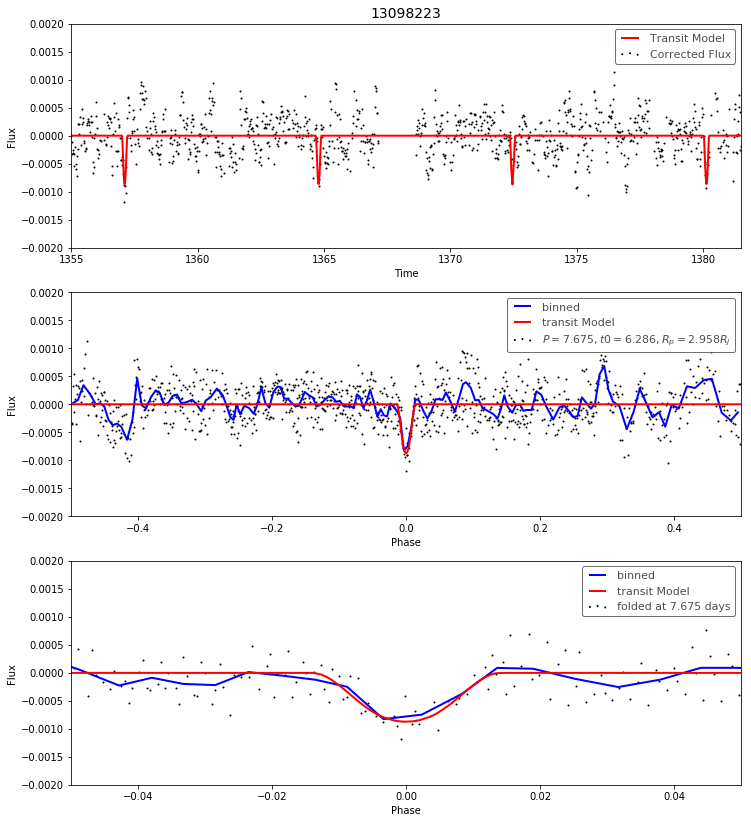

In [27]:
target.plot_starry_model()